# Modelo de riesgos competitivos

Paquetes:

In [2]:
#Utils
import h5py
import matplotlib.pyplot as plt
import sys

#Numeric
import numpy as np

#Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

#ownimport sys
sys.path.append('/home/jmalagont/Documentos/MLDS6project/src/nombre_paquete/training')
import survivalflow as sf

Rutas importantes:

In [3]:
DataSetPath = '/home/jmalagont/Documentos/MLDS6project/src/dataset/TCGA-BRCA.h5'

# 1. Carga de datos

In [4]:
DataSet = h5py.File(DataSetPath,'r+') 
Labels = np.abs(np.array([DataSet['time'], np.array(DataSet['status'])+1]).T)
features = np.array(DataSet['embedding'])

X_train, X_test, Y_train, Y_test = train_test_split(features, Labels, test_size=0.3, random_state=42)

print('Entrenamiento\n==============')
print(f'{len(X_train)} Observaciones, tiempos [{np.min(Y_train[:,0])},{np.max(Y_train[:,0])}]')
print('Test\n==============')
print(f'{len(X_test)} Observaciones, tiempos [{np.min(Y_test[:,0])},{np.max(Y_test[:,0])}]')

Entrenamiento
726 Observaciones, tiempos [0,12205]
Test
312 Observaciones, tiempos [0,13132]


# 2. Modelo

In [5]:
def loss(labels, hazards):
  l = sf.CompetingLogNegativePartialLikelihood(labels, hazards,tf.constant([.2,.8],tf.float64))
  return(l)

In [25]:
K.clear_session()

input = Input(shape=(2048))
mid = Dense(1024, activation = 'relu', use_bias = False, kernel_initializer='normal')(input)
out = Dense(2, activation = 'linear', use_bias = False, kernel_initializer='zeros')(mid)

comp = Model(inputs=[input], outputs=[out], name="comp")
comp.compile(optimizer=Adam(learning_rate=0.0001), loss=loss,  metrics=[sf.mean_harrell_index])
comp.summary()

Model: "comp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2097152   
                                                                 
 dense_1 (Dense)             (None, 2)                 2048      
                                                                 
Total params: 2,099,200
Trainable params: 2,099,200
Non-trainable params: 0
_________________________________________________________________


In [26]:
ES = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience = 100)
training_gen = sf.CompetingSurvivalDataGenerator(X_train, Y_train, comp)
test_gen = sf.CompetingSurvivalDataGenerator(X_test, Y_test, comp)

# 3. Entrenamiento

In [27]:
history = comp.fit(x = training_gen, validation_data = test_gen, epochs=100, callbacks = [ES])

Epoch 1/100


2023-06-16 14:40:28.026708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - ETA: 0s - loss: 5.2785 - mean_harrell_index: 0.0000e+00

2023-06-16 14:40:29.631076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 2s 2s/step - loss: 5.2785 - mean_harrell_index: 0.0000e+00 - val_loss: 5.2475 - val_mean_harrell_index: 0.5669
Epoch 2/100
1/1 [==============================] - 0s 483ms/step - loss: 6.2561 - mean_harrell_index: 0.5387 - val_loss: 4.3632 - val_mean_harrell_index: 0.5974
Epoch 3/100
1/1 [==============================] - 0s 477ms/step - loss: 5.2962 - mean_harrell_index: 0.5666 - val_loss: 4.5641 - val_mean_harrell_index: 0.4893
Epoch 4/100
1/1 [==============================] - 0s 472ms/step - loss: 5.4982 - mean_harrell_index: 0.5062 - val_loss: 4.7340 - val_mean_harrell_index: 0.4877
Epoch 5/100
1/1 [==============================] - 0s 486ms/step - loss: 5.6797 - mean_harrell_index: 0.5025 - val_loss: 4.5611 - val_mean_harrell_index: 0.5229
Epoch 6/100
1/1 [==============================] - 0s 482ms/step - loss: 5.5448 - mean_harrell_index: 0.5132 - val_loss: 4.4014 - val_mean_harrell_index: 0.5745
Epoch 7/100
1/1 [============================

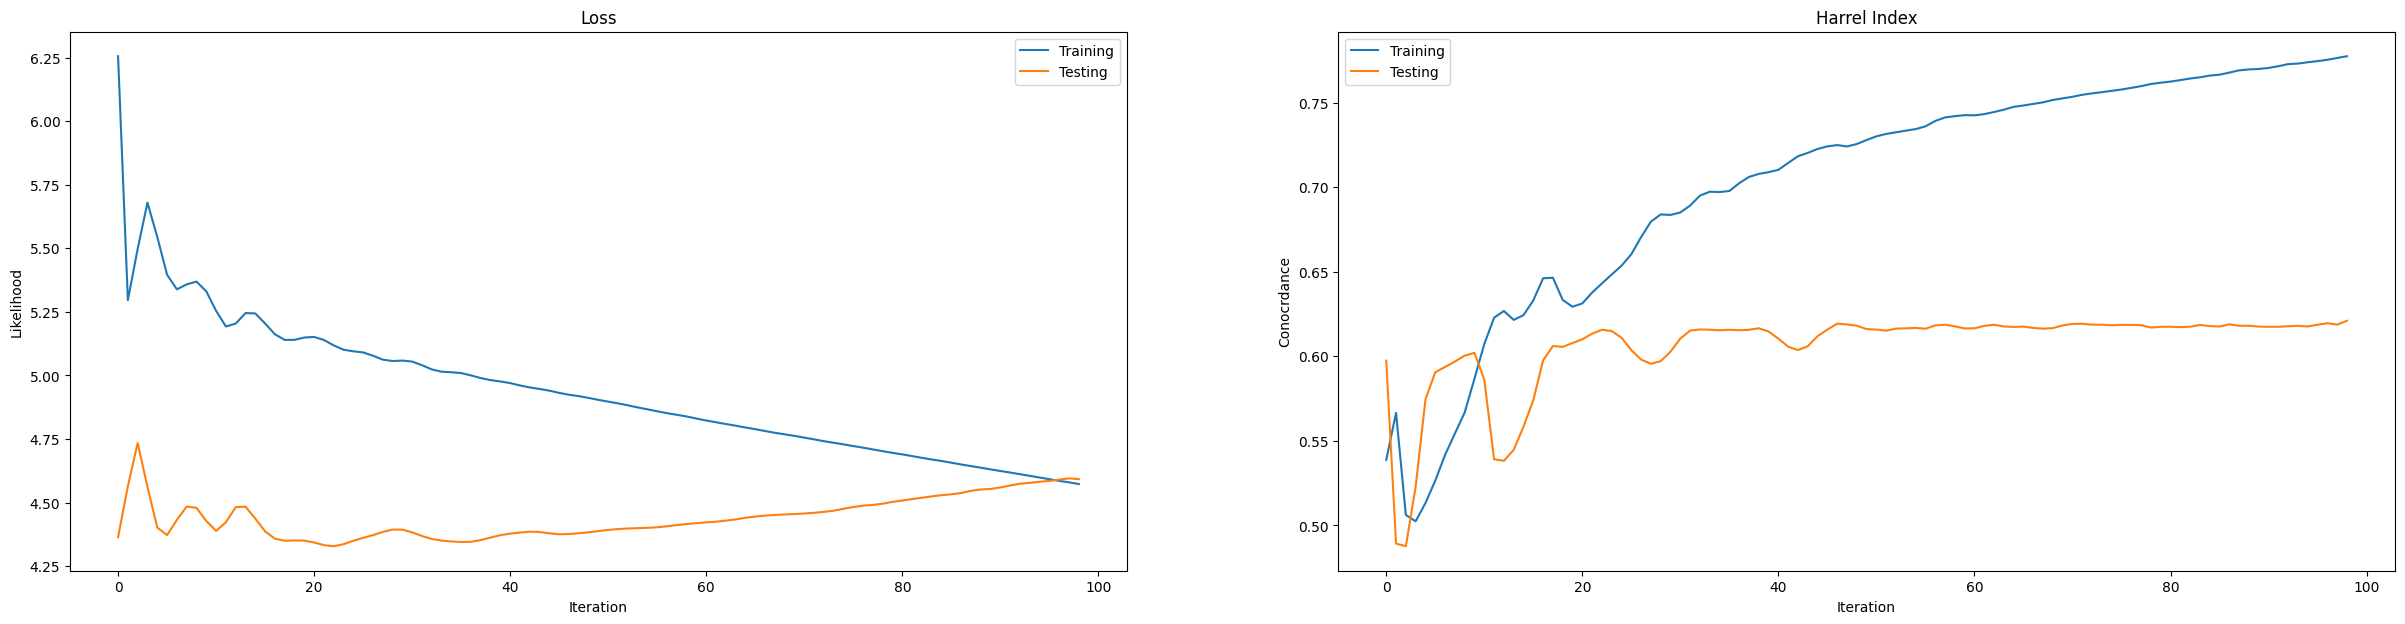

In [28]:
hs = history.history

fig, char = plt.subplots(1,2)
fig.set_size_inches(30, 7)

char[0].plot(hs['loss'][1:], label='Training')
char[0].plot(hs['val_loss'][1:], label='Testing')
char[0].set_title('Loss')
char[0].set_xlabel('Iteration')
char[0].set_ylabel('Likelihood')
char[0].legend()

char[1].plot(hs['mean_harrell_index'][1:], label='Training')
char[1].plot(hs['val_mean_harrell_index'][1:], label='Testing')
char[1].set_title('Harrel Index')
char[1].set_xlabel('Iteration')
char[1].set_ylabel('Conocrdance')
char[1].legend()

plt.show()

# 4. Evaluación

In [30]:
score = comp.evaluate(test_gen, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.592203617095947
Test accuracy: 0.6210259795188904


2023-06-16 14:41:44.789799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
